In this blog, I train a standard CNN model on the MNIST data and assess its performance.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras
import sys
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "3"
#### 2 GPU1
#### 3 GPU2
#### 0 GPU3
#### 4 GPU4

set_session(tf.Session(config=config))

Using TensorFlow backend.


python 2.7.13 |Anaconda 4.3.1 (64-bit)| (default, Dec 20 2016, 23:09:15) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
keras version 2.0.6
tensorflow version 1.2.1


In [2]:
from mnist import MNIST
import numpy as np
from keras.utils import to_categorical

mndata = MNIST('./MNIST_data/')

images, labels = mndata.load_training()
x_train, y_train = np.array(images),np.array(labels)

images, labels = mndata.load_testing()
x_test, y_test = np.array(images),np.array(labels)


x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = to_categorical(y_train.astype('float32'))
y_test = to_categorical(y_test.astype('float32'))
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000, 10), (10000, 10))


## CNN model
I define a standard CNN with three convolutional layers of 256, 256, 128 channels.
Each has 5x5 kernels and stride of 1.
The last convolutional layers are followed by two fully connected layers of size 328, 192.
The last fully connected layer is connected with dropout to a 10 class softmax layer with cross entropy loss.

According to [Recent Hinton's paper](https://arxiv.org/pdf/1710.09829.pdf), "[This model] is designed to achieve the best performance on MNIST" when model complexity is at this level. This model contains 35M parameters.


In [3]:
from keras.layers import Conv2D, MaxPooling2D,Flatten, Dropout, Activation, Dense
from keras.models import Sequential
from keras import optimizers
from numpy.random import seed
from tensorflow import set_random_seed


def StandardCNN(withDropout=False,
              n_class=10,
              input_shape = (96, 96, 1)):
    '''
    WithDropout: If True, then dropout regularlization is added.
    This feature is experimented later.
    '''
    model = Sequential()
    model.add(Conv2D(256,(5, 5), strides=1,
                     activation="relu",padding="same",
                     input_shape = input_shape))## 96 - 3 + 2
    #model.add(MaxPooling2D(pool_size = (2,2))) ## 96 - (3-1)*2
        
    model.add(Conv2D(256,(5, 5), strides=1,
                     activation="relu", padding="same"
                    ))
    #model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(128,(5, 5), strides=1,
                     activation="relu", padding="same"
                    ))
    #model.add(MaxPooling2D(pool_size=(2,2)))
        
    model.add(Flatten())
    
    model.add(Dense(328,activation='relu'))

        
    model.add(Dense(192,activation='relu'))
    ## 1024, 2048, 4096,8192
    model.add(Dropout(0.5))
        
    model.add(Dense(n_class))
    model.add(Activation('softmax',name="output"))
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizers.Adam(lr=0.0005),
                 metrics={'output': 'accuracy'})
    return(model)

model = StandardCNN(input_shape = (28, 28, 1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 256)       6656      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 256)       1638656   
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       819328    
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 328)               32915784  
_________________________________________________________________
dense_2 (Dense)              (None, 192)               63168     
_________________________________________________________________
dropout_1 (Dropout)          (None, 192)               0         
__________

#### Training
We set the number of epochs to be 20.

In [4]:
%%time

seed(1)
set_random_seed(1)

hist1 = model.fit(x_train,
                 y_train,
                 batch_size=64,
                 nb_epoch=20,
                 validation_data=[x_test, y_test],verbose=2)

/home/fairy/anaconda2/lib/python2.7/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
52s - loss: 0.1395 - acc: 0.9581 - val_loss: 0.0349 - val_acc: 0.9884
Epoch 2/20
51s - loss: 0.0480 - acc: 0.9862 - val_loss: 0.0340 - val_acc: 0.9889
Epoch 3/20
51s - loss: 0.0308 - acc: 0.9907 - val_loss: 0.0261 - val_acc: 0.9924
Epoch 4/20
51s - loss: 0.0235 - acc: 0.9933 - val_loss: 0.0336 - val_acc: 0.9912
Epoch 5/20
51s - loss: 0.0183 - acc: 0.9948 - val_loss: 0.0345 - val_acc: 0.9911
Epoch 6/20
50s - loss: 0.0138 - acc: 0.9958 - val_loss: 0.0326 - val_acc: 0.9916
Epoch 7/20
50s - loss: 0.0109 - acc: 0.9969 - val_loss: 0.0280 - val_acc: 0.9918
Epoch 8/20
50s - loss: 0.0097 - acc: 0.9974 - val_loss: 0.0373 - val_acc: 0.9915
Epoch 9/20
50s - loss: 0.0082 - acc: 0.9978 - val_loss: 0.0449 - val_acc: 0.9911
Epoch 10/20
50s - loss: 0.0075 - acc: 0.9977 - val_loss: 0.0413 - val_acc: 0.9908
Epoch 11/20
50s - loss: 0.0065 - acc: 0.9984 - val_loss: 0.0324 - val_acc: 0.9914
Epoch 12/20
50s - loss: 0.0081 - acc: 0.9976 - val_loss: 

The back propagation algorithm seems to converge.

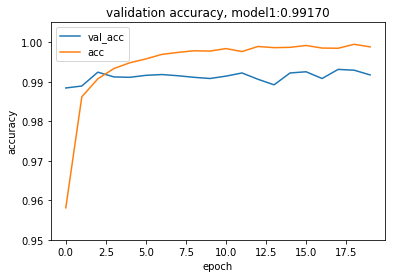

In [5]:
for label in ["val_acc","acc"]:
    plt.plot(hist1.history[label],label=label)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("validation accuracy, model1:{:6.5f}".format(
    hist1.history["val_acc"][-1]))
plt.legend()
plt.ylim(0.95,1.005)
plt.show()

# Train the model with data augmentation
I now train the same model with image translation.
"translation of image" means shifting image by costant value to right, left, up or down, or some combinations of these.

Keras provides the ImageDataGenerator class that defines the configuration for image data preparation and augmentation.
Rather than performing the operations on your entire image dataset in memory, the ImageDataGenerator API is designed to be iterated by the deep learning model fitting process, creating augmented image data for you just-in-time. 
This reduces your memory overhead, but adds some additional time cost during model training.

I discussed the useage of ImageDataGenerator in [previous blog post](https://fairyonice.github.io/Learn%20about%20ImageDataGenerator.html).
I also found [Jason Brownlee's blog](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/) is very useful for learning ImageDataGenerator.

##  train_generator
First, define train_generator method which infenitely return training and testing batch.
batch_size determines the batch size.
generator.next() randomly select batch_size many samples from x_train, 
then the random transformation is applied to the selected images.

If the x_train.shape[0] < batch_size, the returned batch_size is x_train.shape[0].

In [6]:
from keras.preprocessing.image import ImageDataGenerator

def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator( width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            ## x_batch.shape = (bsize,28,28,1)
            ## where bsize = np.min(batch_size,x.shape[0])
            yield ([x_batch, y_batch])

The following code shows the images generated by train_generator when only 5 images are fed into the train_generator.
Although the batch_size is set to 1,000, every batch only yields 5 transformed images, and original image is transoformed only once.


((5, 28, 28, 1), (5, 10))


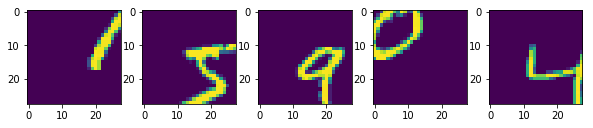

((5, 28, 28, 1), (5, 10))


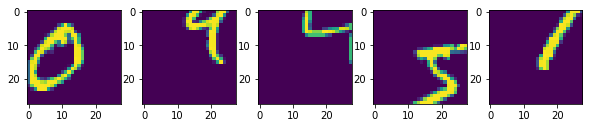

In [7]:
def plot_sample(x_train,y_train,batch_size,shift_fraction=0.4):
    count = 0 
    for generator in train_generator(x_train, y_train, batch_size, shift_fraction):
        x_tra, y_tra = generator
        count += 1
        if count > 0:
            break
        
    print(x_tra.shape,y_tra.shape)
    
    n = 5
    fig = plt.figure(figsize=(10,10))        
    for i in range(x_tra.shape[0]):    
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(x_tra[i].reshape(28,28))
        if (n*n) < (i + 2):
            break
    plt.show()
    
plot_sample(x_train[:5],y_train[:5],batch_size=1000,shift_fraction=0.4)
plot_sample(x_train[:5],y_train[:5],batch_size=1000,shift_fraction=0.4)

## Model training


I will set the shift_fraction = 0.1.
This means that each image is shifted at most 3 pixels (28x0.1 = 2.8).
I noticed that fit_generator causes error messages when steps_per_epoch is NOT specified. This is "Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch."

In [8]:
%%time

seed(1)
set_random_seed(1)

batch_size = 64
model2 = StandardCNN(input_shape = (28, 28, 1))
hist2 = model2.fit_generator(
                        generator=train_generator(x_train, y_train, batch_size, 0.1),
                        epochs=20,
                        verbose=2,
                        steps_per_epoch=int(y_train.shape[0] / batch_size),
                        validation_data=[x_test, y_test])#,callbacks=[log, checkpoint, lr_decay])

Epoch 1/20
51s - loss: 0.2261 - acc: 0.9295 - val_loss: 0.0298 - val_acc: 0.9899
Epoch 2/20
50s - loss: 0.0744 - acc: 0.9790 - val_loss: 0.0329 - val_acc: 0.9884
Epoch 3/20
50s - loss: 0.0512 - acc: 0.9858 - val_loss: 0.0330 - val_acc: 0.9900
Epoch 4/20
50s - loss: 0.0418 - acc: 0.9879 - val_loss: 0.0280 - val_acc: 0.9911
Epoch 5/20
50s - loss: 0.0380 - acc: 0.9890 - val_loss: 0.0191 - val_acc: 0.9939
Epoch 6/20
50s - loss: 0.0332 - acc: 0.9908 - val_loss: 0.0206 - val_acc: 0.9934
Epoch 7/20
50s - loss: 0.0292 - acc: 0.9913 - val_loss: 0.0276 - val_acc: 0.9924
Epoch 8/20
50s - loss: 0.0267 - acc: 0.9927 - val_loss: 0.0195 - val_acc: 0.9936
Epoch 9/20
50s - loss: 0.0247 - acc: 0.9928 - val_loss: 0.0166 - val_acc: 0.9949
Epoch 10/20
50s - loss: 0.0212 - acc: 0.9938 - val_loss: 0.0176 - val_acc: 0.9949
Epoch 11/20
50s - loss: 0.0208 - acc: 0.9941 - val_loss: 0.0197 - val_acc: 0.9945
Epoch 12/20
50s - loss: 0.0178 - acc: 0.9945 - val_loss: 0.0172 - val_acc: 0.9949
Epoch 13/20
50s - loss: 0

## Result
The final validation accuracy is 0.995 (the validation error is 0.540%).
The data augmentation approach improved the validation accuracy by 0.0029.
As the validation data contains 10K images, this means that additional 29 (=10000x0.0029) images are correctly classified. 

According to [Recent Hinton's paper](https://arxiv.org/pdf/1710.09829.pdf), this model could return the validation error of 0.39%. My final model is not as good. I probablly need to tweek the backpropagation parameters and dropout rate. 


#### Some comments on algorithm's termination criteria
In this excercise, I did not formaly split the data into train, validation and test sets.
Instead, I treated testing data also as a validation data.
This is OK if testing data is not used for deciding the model parameter updates.
However, it is NOT OK if the testing data is used for this purpose, e.g., deciding when to terminate the algorithm.

I selected the model updated at the final epoch as the final model; my algorithm termination criteria is simply "stop at 50th epoch".
This simple approach may cause issues, because the model may be overfitted or underfitted at the pre-specified epoch size. It is wiser to decide the final model by introducing validation set and considering the early stopping when the validation loss is minimized. 


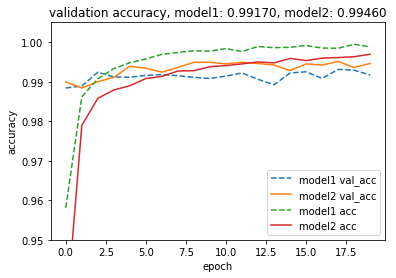

validation error:
    model1: 0.830%, model2: 0.540%
validation accuracy improvement: 0.0029


In [23]:
m1_err = hist1.history["val_acc"][-1]
m2_err = hist2.history["val_acc"][-1]
for label in ["val_acc","acc"]:
    plt.plot(hist1.history[label],"--",label="model1 " + label)
    plt.plot(hist2.history[label],label="model2 " + label)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("validation accuracy, model1: {:6.5f}, model2: {:6.5f}".format(
    m1_err,m2_err))
plt.legend()
plt.ylim(0.95,1.005)
plt.show()
print("validation error:\n    model1: {:5.3f}%, model2: {:5.3f}%".format(
    (1-m1_err)*100,(1-m2_err)*100))
print("validation accuracy improvement: {}".format(m2_err-m1_err))

### Save model

In [10]:
from keras.models import model_from_json
def save_model(model,name):
    '''
    save model architecture and model weights
    '''
    json_string = model.to_json()
    open(name+'_architecture.json', 'w').write(json_string)
    model.save_weights(name+'_weights.h5')

save_model(model2,name="standard")    

Due to the large number of parameters (35M), the model weight object is hudge!

In [11]:
import os 
file_paths = ["standard_weights.h5","standard_architecture.json"]
for file_path in file_paths:
    w = os.stat(file_path).st_size
    print("{:30} {:4.2f} MB".format(file_path,w/(1024.0**2)))

standard_weights.h5            135.24 MB
standard_architecture.json     0.00 MB
